In [161]:
import pandas as pd

In [162]:
data = pd.read_csv('metrics.csv')

print(data.head())

             instance            timestamp metric_name     value
0  node-exporter:9100  2024-12-09 22:15:51   cpu_usage  0.251333
1  node-exporter:9100  2024-12-09 22:16:51   cpu_usage  0.499300
2  node-exporter:9100  2024-12-09 22:17:51   cpu_usage  0.161989
3  node-exporter:9100  2024-12-09 22:23:05   cpu_usage  0.092667
4  node-exporter:9100  2024-12-09 22:24:06   cpu_usage  0.079568


Check for missing or duplicate rows

In [163]:
# Check column types and data info
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Check for duplicates
print()
print('duplicated values:', data.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   instance     111 non-null    object 
 1   timestamp    111 non-null    object 
 2   metric_name  111 non-null    object 
 3   value        111 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.6+ KB
None
instance       0
timestamp      0
metric_name    0
value          0
dtype: int64

duplicated values: 36


Convert timestamp to Datetime

In [164]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [165]:
# Extract time-based features
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) # monday=0, sunday=6


In [166]:
print(data[['timestamp', 'hour', 'day_of_week', 'is_weekend']].head())

            timestamp  hour  day_of_week  is_weekend
0 2024-12-09 22:15:51    22            0           0
1 2024-12-09 22:16:51    22            0           0
2 2024-12-09 22:17:51    22            0           0
3 2024-12-09 22:23:05    22            0           0
4 2024-12-09 22:24:06    22            0           0


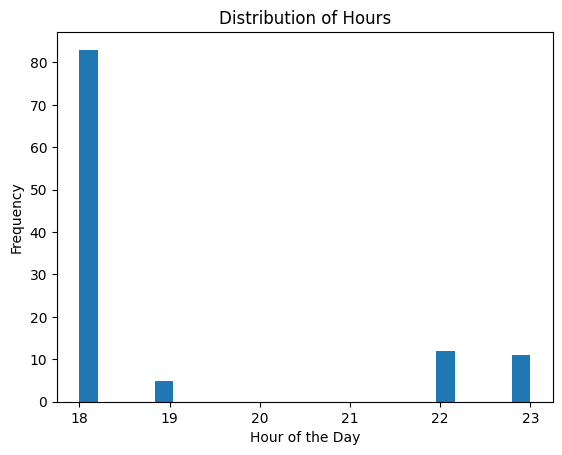

In [167]:
import matplotlib.pyplot as plt

data['hour'].hist(bins=24, grid=False)
plt.title('Distribution of Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()


Monday - 0, Sunday - 6

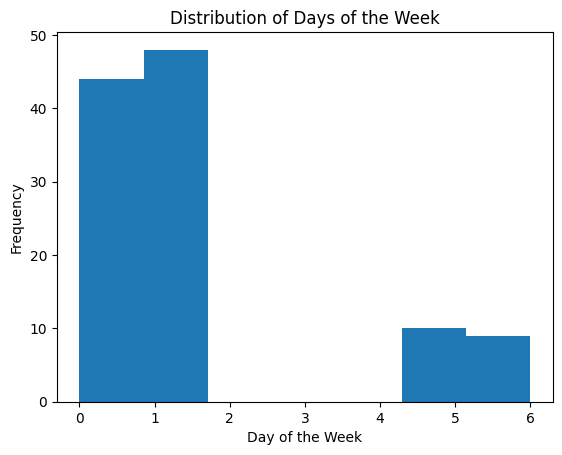

In [168]:
data['day_of_week'].hist(bins=7, grid=False)
plt.title('Distribution of Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.show()

 Normalize the value Column
 Using the MinMaxScaler from scikit-learn, we can normalize the value column to a range between 0 and 1.

In [169]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data["scaled_value"] = scaler.fit_transform(data[["value"]])

print(data[['value', 'scaled_value']].head())



      value  scaled_value
0  0.251333      0.411671
1  0.499300      0.874275
2  0.161989      0.244991
3  0.092667      0.115664
4  0.079568      0.091227


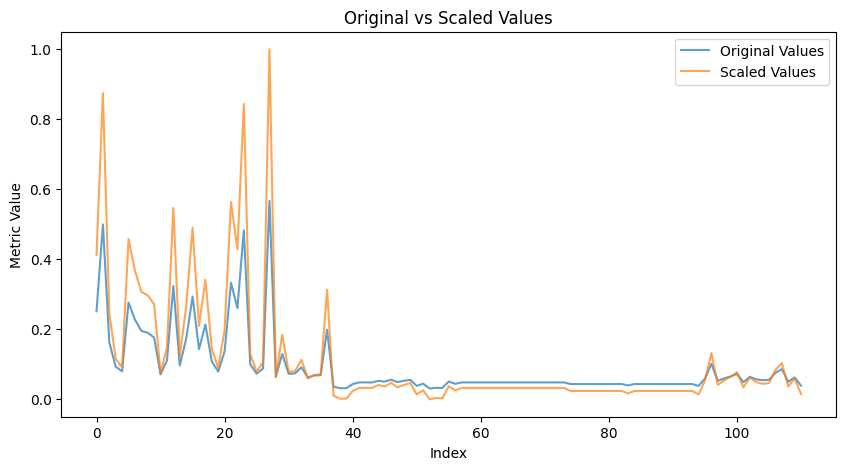

In [170]:
plt.figure(figsize=(10, 5))

# Original values
plt.plot(data['value'], label='Original Values', alpha=0.7)

# Scaled values
plt.plot(data['scaled_value'], label='Scaled Values', alpha=0.7)

plt.legend()
plt.title('Original vs Scaled Values')
plt.xlabel('Index')
plt.ylabel('Metric Value')
plt.show()

Create Lag Features and Rolling Statistics

Lagging and rolling features help capture temporal patterns, which are crucial for time-series tasks.

Lag Features:
Create columns with previous values of the metric.
Example: value_lag1 is the value from the last timestamp.

Rolling Statistics:

Compute moving averages or sums over a window of time.
Example: rolling_avg_3 is the average of the last 3 values.


In [171]:
# Create lag features
data['value_lag1'] = data['scaled_value'].shift(1)
data['value_lag2'] = data['scaled_value'].shift(2)

# Create rolling features
data['rolling_avg_3'] = data['scaled_value'].rolling(window=3).mean()
data['rolling_std_3'] = data['scaled_value'].rolling(window=3).std()

# Drop rows with NaN values (caused by lag/rolling operations)
data = data.dropna()

print(data)

               instance           timestamp metric_name     value  hour  \
2    node-exporter:9100 2024-12-09 22:17:51   cpu_usage  0.161989    22   
3    node-exporter:9100 2024-12-09 22:23:05   cpu_usage  0.092667    22   
4    node-exporter:9100 2024-12-09 22:24:06   cpu_usage  0.079568    22   
5    node-exporter:9100 2024-12-09 22:53:35   cpu_usage  0.276222    22   
6    node-exporter:9100 2024-12-09 22:54:35   cpu_usage  0.227581    22   
..                  ...                 ...         ...       ...   ...   
106  node-exporter:9100 2024-12-10 19:00:16   cpu_usage  0.075556    19   
107  node-exporter:9100 2024-12-10 19:01:16   cpu_usage  0.086002    19   
108  node-exporter:9100 2024-12-10 19:02:16   cpu_usage  0.050216    19   
109  node-exporter:9100 2024-12-10 19:03:16   cpu_usage  0.062221    19   
110  node-exporter:9100 2024-12-10 19:04:16   cpu_usage  0.038666    19   

     day_of_week  is_weekend  scaled_value  value_lag1  value_lag2  \
2              0           0 

Split the Data for Training and Testing

In [172]:
# Sort data by timestamp
data = data.sort_values(by='timestamp')

split_index = int(0.8 * len(data))

# Split into training and testing sets
train = data[:split_index]
test = data[split_index:]

print('Training Set:', train.shape)
print('Testing Set:', test.shape)

X_train = train[['value_lag1', 'value_lag2', 'rolling_avg_3', 'rolling_std_3']]
y_train = train['scaled_value']

X_test = test[['value_lag1', 'value_lag2', 'rolling_avg_3', 'rolling_std_3']]
y_test = test['scaled_value']

Training Set: (87, 12)
Testing Set: (22, 12)


Train a Machine Learning Model

Regression Model (Regression Linear Model)

In [173]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

In [174]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Mean Absolute Error: 1.932442526704618e-16
R-squared: 1.0


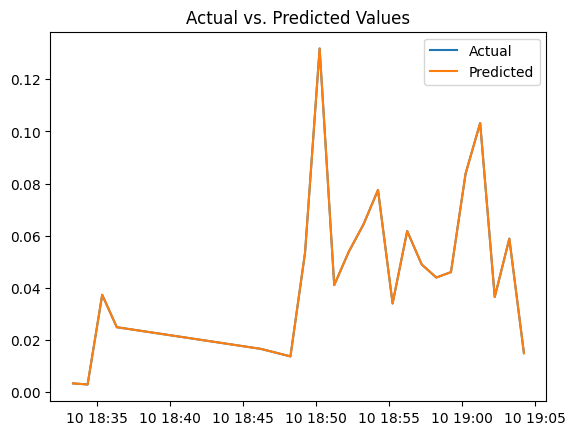

In [175]:
import matplotlib.pyplot as plt

plt.plot(test['timestamp'], y_test, label='Actual')
plt.plot(test['timestamp'], predictions, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Values')
plt.show()
